In [4]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt
import tensorflow_hub as hub

In [5]:
df = pd.read_csv("simplified_coffee.csv",usecols=["name","roaster", "roast","loc_country","rating","review"])

In [6]:
df.head()

,name,roaster,roast,loc_country,rating,review
0,Ethiopia Shakiso Mormora,Revel Coffee,Medium-Light,United States,92,"Crisply sweet, cocoa-toned. Lemon blossom, roa..."
1,Ethiopia Suke Quto,Roast House,Medium-Light,United States,92,"Delicate, sweetly spice-toned. Pink peppercorn..."
2,Ethiopia Gedeb Halo Beriti,Big Creek Coffee Roasters,Medium,United States,94,"Deeply sweet, subtly pungent. Honey, pear, tan..."
3,Ethiopia Kayon Mountain,Red Rooster Coffee Roaster,Light,United States,93,"Delicate, richly and sweetly tart. Dried hibis..."
4,Ethiopia Gelgelu Natural Organic,Willoughby's Coffee & Tea,Medium-Light,United States,93,"High-toned, floral. Dried apricot, magnolia, a..."


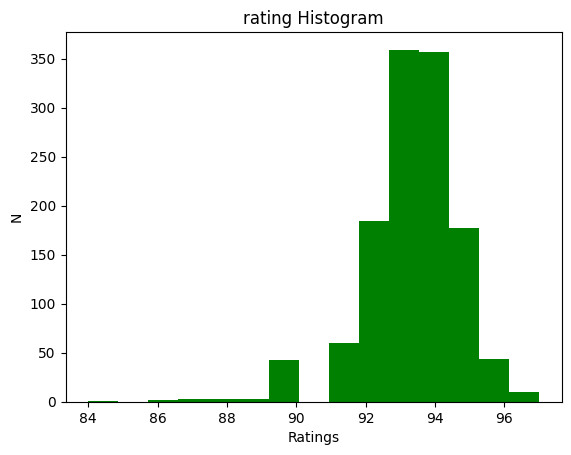

In [7]:
plt.hist(df.rating,bins=15, color='green')
plt.title("rating Histogram")
plt.ylabel("N")
plt.xlabel("Ratings")
plt.show()

In [8]:
df['rating']=(df.rating>=90).astype(int)
df=df[["review","rating"]]

In [9]:
train,val,test = np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [10]:
len(train),len(val),len(test)

(996, 125, 125)

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('rating')
  df = df["review"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [12]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [13]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [14]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(32, 50), dtype=float32, numpy=
array([[ 0.50948817, -0.14242403, -0.13518228, ...,  0.01555949,
        -0.08217138,  0.00899064],
       [ 0.8108794 , -0.29567894, -0.11317798, ..., -0.20102404,
        -0.14347468,  0.05689607],
       [ 0.6773847 , -0.39400616, -0.14800252, ...,  0.001968  ,
        -0.0854352 ,  0.17180441],
       ...,
       [ 0.6352274 , -0.32611898, -0.33553442, ..., -0.11087088,
        -0.19895065,  0.11826079],
       [ 0.6115783 , -0.23410507, -0.03852198, ...,  0.039404  ,
        -0.00598806, -0.09653591],
       [ 0.680893  , -0.34816927, -0.24764583, ..., -0.00510929,
        -0.17540431, -0.07862258]], dtype=float32)>

In [15]:
model= tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32,activation="relu"))

model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(32,activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(),
metrics=['accuracy'])

In [17]:
model.evaluate(train_data)

32/32 [==============================] - 1s 3ms/step - loss: 0.6402 - accuracy: 0.9428


[0.6402181386947632, 0.9427710771560669]

In [18]:
model.evaluate(valid_data)

4/4 [==============================] - 0s 6ms/step - loss: 0.6395 - accuracy: 0.9200


[0.6394822597503662, 0.9200000166893005]

In [19]:
history=model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
32/32 [==============================] - 40s 1s/step - loss: 0.3819 - accuracy: 0.9468 - val_loss: 0.1058 - val_accuracy: 1.0000
Epoch 2/5
32/32 [==============================] - 39s 1s/step - loss: 0.1022 - accuracy: 0.9910 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 3/5
32/32 [==============================] - 37s 1s/step - loss: 0.0665 - accuracy: 0.9910 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 4/5
32/32 [==============================] - 37s 1s/step - loss: 0.0540 - accuracy: 0.9910 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 5/5
32/32 [==============================] - 36s 1s/step - loss: 0.0490 - accuracy: 0.9910 - val_loss: 0.0028 - val_accuracy: 1.0000


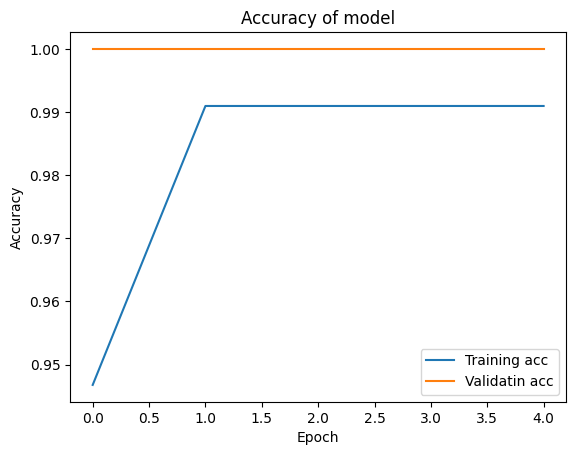

In [20]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validatin acc')
plt.title("Accuracy of model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

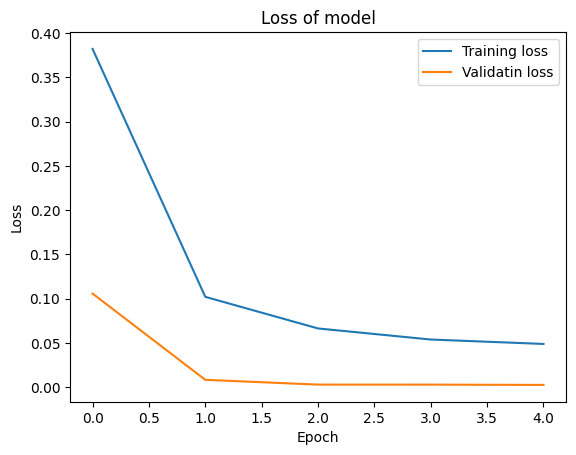

In [21]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validatin loss')
plt.title("Loss of model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
model.evaluate(test_data)

4/4 [==============================] - 1s 147ms/step - loss: 0.1436 - accuracy: 0.9760


[0.14355632662773132, 0.9760000109672546]

#LSTM

In [25]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, review:text))

In [26]:
vocab= np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'in', 'with', 'cup', 'aroma', 'finish',
       'mouthfeel', 'the', 'structure', 'acidity', 'of', 'chocolate',
       'sweet', 'notes', 'cocoa', 'richly', 'sweetly', 'nib'],
      dtype='<U21')

In [28]:
model=tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),

    output_dim = 32,
    mask_zero= True
        ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32,activation="relu"),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(1,activation="sigmoid"),

])

In [30]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001), loss=tf.keras.losses.BinaryCrossentropy(),
metrics=["accuracy"])

In [31]:
model.evaluate(train_data)
model.evaluate(valid_data)

4/4 [==============================] - 0s 10ms/step - loss: 0.6960 - accuracy: 0.1120


[0.6960445642471313, 0.1120000034570694]

In [32]:
history= model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
32/32 [==============================] - 6s 34ms/step - loss: 0.5234 - accuracy: 0.9548 - val_loss: 0.0910 - val_accuracy: 1.0000
Epoch 2/5
32/32 [==============================] - 1s 32ms/step - loss: 0.0813 - accuracy: 0.9910 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 3/5
32/32 [==============================] - 2s 50ms/step - loss: 0.0687 - accuracy: 0.9910 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 4/5
32/32 [==============================] - 1s 31ms/step - loss: 0.0659 - accuracy: 0.9910 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 5/5
32/32 [==============================] - 2s 71ms/step - loss: 0.0613 - accuracy: 0.9910 - val_loss: 0.0057 - val_accuracy: 1.0000
